**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Higher order income risk](#toc1_)    
- 2. [Problem 2: Inflation in an exchange model](#toc2_)    
- 3. [Problem 3: Segregation model](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [11]:
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
from matplotlib import colors
from scipy.optimize import *

%load_ext autoreload 
%autoreload 2

from opg2 import opg2_class
model = opg2_class()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Higher order income risk](#toc0_)

We consider a consumer living in **two periods**. In the **second period** she behaves as:

$$
\begin{align*}
v_{2}(m_{2})	&=\max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho} \\
	&\text{s.t.} \\
a_{2}	&=m_{2}-c_{2} \\
a_{2}	&\geq0 \\
\end{align*}
$$

This implies:

$$
v_{2}(m_{2})=\frac{m_{2}^{1-\rho}}{1-\rho}
$$

In the **first period**, the consumer solves:

$$
\begin{align*}
v_{1}(m_{1})	&=\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_{2}(m_{2})\right] \\
	&\text{s.t.} \\
a_{1}	&=m_{1}-c_{1} \\
a_{1}	&\geq0 \\
m_{2}	&=(1+r)a_{1}+y_{2} \\

y_{2}	&= \begin{cases}
1 & \nu_2 < \pi\\
\exp(\psi_2) & \text{else}
\end{cases} \\
\psi_2	&\sim\mathcal{N}(-0.5\sigma_{\psi}^{2},\sigma_{\psi}^{2}) \\
\nu_2	&\sim\mathcal{U}(0,1) \\
\end{align*}
$$

The standard random variables $\psi_2$ and $\nu_2$ are approximated with $N$ random draws.

The initial value of cash-on-hand is $m_1 = 1.0$.
The baseline parameters are as in the code below.

In [12]:
par = SimpleNamespace()

par.beta = 0.90
par.rho = 2.0
par.r = 0.05    
par.pi = 0.50
par.sigma_psi = 0.10

par.m1 = 2.0
par.N = 100_000

**Questions 1:** Plot the distribution of $y_2$.

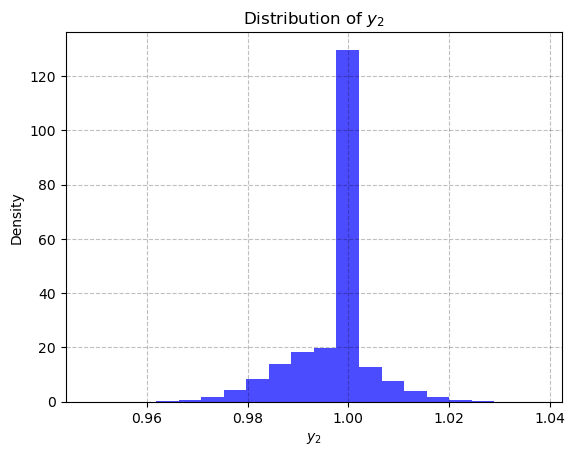

Mean of y2: 1.00
Median of y2: 1.00
Std Dev of y2: 0.01


In [17]:
# We perform a Monte Carlo simulation to generate values for y2
psi2_draws = np.random.normal(-0.5 * par.sigma_psi**2, par.sigma_psi**2, par.N) # Draw from the distribution of psi2
nu2_draws = np.random.uniform(0, 1, par.N) # Draw from the distribution of nu2
y2_values = np.where(nu2_draws < par.pi, 1, np.exp(psi2_draws)) # Calculate y2

# We set a random seed to ensure that we get the same results every time we run the code
np.random.seed(2023)

# Plot the distribution of y2
plt.hist(y2_values, bins=20, density=True, alpha=0.7, color='blue')
plt.xlabel('$y_2$')
plt.ylabel('Density')
plt.title('Distribution of $y_2$')

# Calculate summary statistics
mean_y2 = np.mean(y2_values)
median_y2 = np.median(y2_values)
std_dev_y2 = np.std(y2_values)

# Plot the distribution of y2
plt.show()
print((f"Mean of y2: {mean_y2:.2f}\nMedian of y2: {median_y2:.2f}\nStd Dev of y2: {std_dev_y2:.2f}"))


**Question 2:** Find the optimal choice of $c_1$ and the implied $v(m_1)$.

Optimal first-period consumption: 1.999986571095652
Implied value function v(m1): -0.7905561244657054


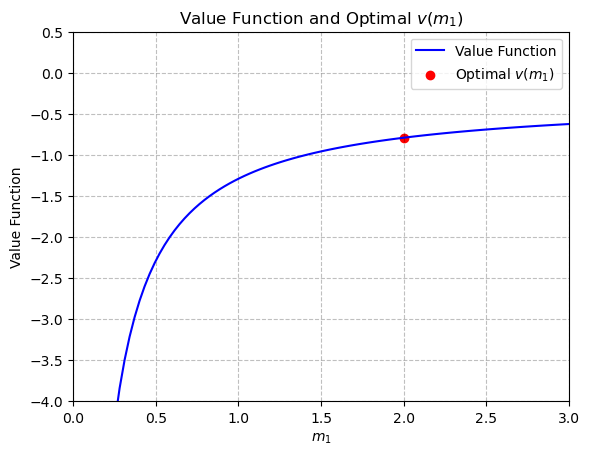

In [18]:
# Define parameters
par = SimpleNamespace()
par.beta = 0.90
par.rho = 2.0
par.r = 0.05
par.pi = 0.50
par.sigma_psi = 0.10
par.m1 = 2.0
par.N = 100_000

# Function to calculate utility in the second period
def utility_second_period(m2):
    return m2**(1 - par.rho) / (1 - par.rho)

# Perform Monte Carlo simulation to approximate the second-period value function
def monte_carlo_second_period(a1_value):
    a1_value = par.m1
    psi2_draws = np.random.normal(-0.5 * par.sigma_psi**2, par.sigma_psi**2, par.N)
    nu2_draws = np.random.uniform(0, 1, par.N)
    y2_values = np.where(nu2_draws < par.pi, 1, np.exp(psi2_draws))
    m2_values = (1 + par.r) * a1_value + y2_values
    expected_utility = np.mean(utility_second_period(m2_values))
    return expected_utility

# Calculate the first-period utility with the expectation from the second period
def calculate_first_period_utility(c1, a1_value):
    m2_expectation = monte_carlo_second_period(a1_value)
    return c1**(1 - par.rho) / (1 - par.rho) + par.beta * m2_expectation

# Optimize the first-period consumption choice using numerical optimization
optimal_c1_result = minimize_scalar(lambda c1: -calculate_first_period_utility(c1, par.m1), bounds=(0, par.m1), method='bounded')
optimal_c1 = optimal_c1_result.x

# Calculate the corresponding value function v(m1)
m2_expectation = monte_carlo_second_period(par.m1)
value_function_m1 = calculate_first_period_utility(optimal_c1, par.m1)

# Print results
print("Optimal first-period consumption:", optimal_c1)
print("Implied value function v(m1):", value_function_m1)

# Plot the value function v(m1)
m1_vals = np.linspace(0.01, 3, 100)
value_function_vals = np.zeros_like(m1_vals)
for i, m1_val in enumerate(m1_vals):
    value_function_vals[i] = calculate_first_period_utility(m1_val, par.m1)
plt.plot(m1_vals, value_function_vals, color='blue', label='Value Function')
plt.scatter(par.m1, value_function_m1, color='red', label='Optimal $v(m_1)$')
plt.ylim(-4, 0.5)
plt.xlim(0, 3)
plt.xlabel('$m_1$')
plt.ylabel('Value Function')
plt.title('Value Function and Optimal $v(m_1)$')
plt.legend()
plt.show()


**Question 3:** Plot combinations of $(\pi,\sigma_{\psi})$ implying that $v(m_1)$ is unchanged. Comment.

In [5]:
# write your answer here

## 2. <a id='toc2_'></a>[Problem 2: Inflation in an exchange model](#toc0_)

Consider an exchange economy with two agents, $A$ and $B$ each with their own distinct good. Their endowment are $e_A$ and $e_B$. Agent $A$ is the buyer, she takes the relative price of the two goods, $p$, as given and chooses the amount of agent $B$'s good to exchange for her own. Agent $B$ is the seller, she sets the relative price between the goods, optimally taking into account $A$'s demand.

**Agent $A$, the buyer, solves:**
$$
\begin{align}
V_{A}(p) = \max_{c,c'} u_A(c,c') \\ s.t. \; c+pc'=e_{A} \\
\end{align}
$$
Or simply:
$$
\begin{align}
V_{A}(p) = \max_{c'} u_A(e_{A}-pc',c')  \\
\end{align}
$$
Where $c$ is consumption of her own good and $c'$ is consumption of the other good.<br>
$u_A$ is her utility function. <br>
This optimization yields the optimal demand function:
$$
\begin{align}
\Rightarrow c' = D(p)
\end{align}
$$

**Agent $B$, the seller, solves:**
\begin{align}
p^* \equiv \arg\max_p v_B(p) \\
\end{align}
where
\begin{align}
\;\,v_B(p) \equiv u_B(e_B-D(p),pD(p))
\end{align}

$u_B$ is her utility function in consumption of her own good (intital endowment, $e_B$, minus what is sold, $D(p)$), and consumption of the other good ($pD(p)$) obtained through trade. $v_B(p)$ is her indirect utility, when the price is $p$, taking into account the optimal demand of the buyer.

Assume that agents are symmetric with quasi-linear utility functions:
\begin{align}
u_A=u_B=u(c,c') = c+ \frac{(c')^{1-\frac{1}{\epsilon}} }{1-\frac{1}{\epsilon}}
\end{align}
And also have equal endownment $e_A = e_B=10$.

Assume the following parameter value:
- $\epsilon = 10.$

**Question 1:** Nummerically solve, and illustrate optimal demand of the buyer, $A$, in the range $p\in [1,2]$. Verify that what you find numerically is equal to the analytical solution, $D(p)=p^{-\epsilon},\,p\geq1$ 

c:\Users\adamk\OneDrive\Skrivebord\UNI\6. Semester\Intro Programming\projects-2023-joost-adam-og-frederik\examproject\opg2.py:32: RuntimeWarning: invalid value encountered in double_scalars
  U_A = par.e_A - par.p*c_mark + c_mark**(1-1/par.epsilon)/(1-1/par.epsilon)


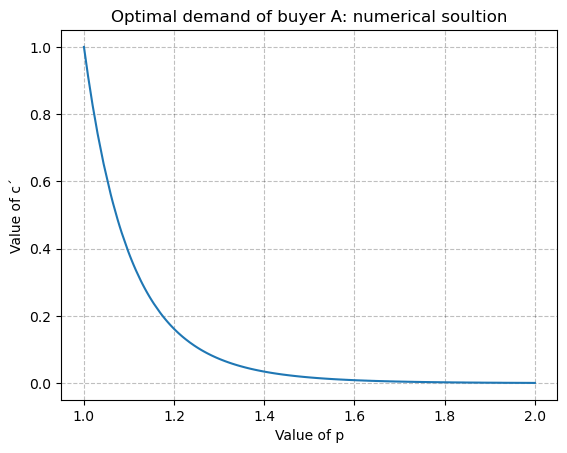

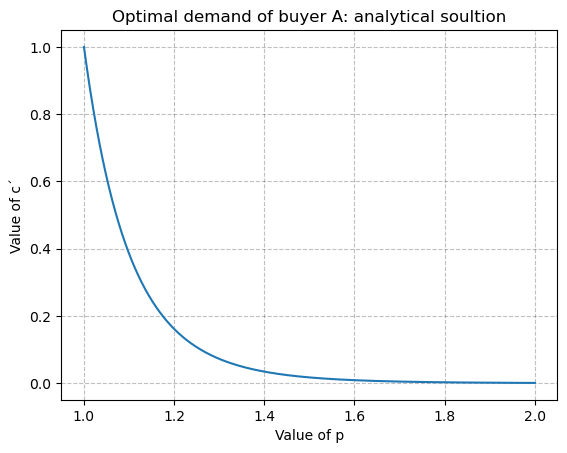

In [6]:
model.solve_p_vec() #Call the function from opg2.py file

#Create plot for optimal demand of buyer A
plt.plot(model.par.p_vec, model.sol.c_mark_vec)
plt.title('Optimal demand of buyer A: numerical soultion')
plt.xlabel('Value of p')
plt.ylabel('Value of c´')
plt.show()

#Compare with the analytical solution
analytical_list = []
for p in model.par.p_vec:
    analytical_list.append(p**(-model.par.epsilon))
plt.plot(model.par.p_vec,analytical_list)
plt.title('Optimal demand of buyer A: analytical soultion')
plt.xlabel('Value of p')
plt.ylabel('Value of c´')
plt.show()


We see the demand-curves after c' are the same for the numerical and analytical soultion. You could also print all the values for both soultions and compare, but that would take to much space.

**Question 2:** Solve the seller's problem numerically, taking into account optimal demand of the buyer. Verify that what you find numerically is equal to the analytical solution: $p^* = \left(\frac{\epsilon}{\epsilon-1} \right)^\frac{\epsilon}{2\epsilon-1}$. <br>
*Hint:* For this problem you can use the analytical solution to $D(p)$, but it is recomended that you use the numerical solution to $D(p)$ from question 1, and nest that when solving the seller's problem, as you will need to do that in the next question.

In [7]:
model.utility_B_num()
p_star = (model.par.epsilon/(model.par.epsilon-1))**(model.par.epsilon/(2*model.par.epsilon-1))
print(p_star)



1.057019233441802


In [8]:
model.solve_U_A()
model.solve_p_vec()

array([1.00000000e+00, 9.99023438e-01, 9.98046875e-01, ...,
       9.76562500e-04, 9.76562500e-04, 9.76562500e-04])

In [9]:
model.utility_B_list()

AttributeError: 'types.SimpleNamespace' object has no attribute 'U_B'

Now consider a fully non-linear utility function, for both agents:
\begin{align}
u_A = u_B = u(c,c') = \frac{(c)^{1-\frac{1}{\eta}} }{1-\frac{1}{\eta}}+ \frac{(c')^{1-\frac{1}{\epsilon}} }{1-\frac{1}{\epsilon}}
\end{align}

**Question 3:** Solve for $p^*$ for the fully non-linear utility function, for $\eta \in \left\{1000,10\right\}$ <br>
*Hint:* Note that this requires both solving the buyer's problem and the seller's problem numerically. 

In [ ]:
# write your answer here

**Question 4:** Make two plots of $p^*$, both with $\eta=10$ and $e_{B}=10$: 
- One of how $p^*$ changes with $\epsilon\in \left[5,30\right]$ and $e_{A}=10$
- One of how $p^*$ changes with $e_{A}\in \left[2.5,30\right]$ and $\epsilon=10$

In [ ]:
# write your answer here

## 3. <a id='toc3_'></a>[Problem 3: Segregation model](#toc0_)

**Definitions:**

We imagine a world, which can be described by a $30\times30$ grid of *positions*.

Initially, each position is *filled* by a person with a 80 percent probability, and otherwise it is *empty*.

If *filled* initially, it is a fifty-fifty chance whether the person belongs to group *red* or group *blue*.

We define a *neighborhood* of a position as the up to 8 positions only one step away in either direction (up/down, left/right, corners).

A person is *satisfied* if her group is not the minority in her neighborhood,

**Each period the following things happen:**

1. A random person is given the possibility to move.

2. The chosen person search empty positions at random. 

3. A move happens immediatly when an unsatisfied person finds an empty position where she is satisfied, and the period ends.

The code below creates the initial map.

In [ ]:
np.random.seed(123)
dim = 30
map = np.random.choice([0,1,2],size=(dim,dim),p=[0.20,0.40,0.40])

def display(map):
    
    cmap = colors.ListedColormap(['white','red', 'blue'])
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.grid(False)
    ax.pcolormesh(map,edgecolor='black',cmap=cmap)
    plt.show()

display(map)

**Question:** Simulate forwards for 10,000 periods and show how the world looks. Calculate the initial and final average number of same-group persons in the neighborhood of each person. Comment. <br>*You can use the code below with the functions `neigborhood` and `satisfied` to start from*.

In [ ]:
def neighborhood(group,i,j):
    """ find the number of same and different persons as group in the neighborhood of (i,j) 

    Args:

        group (int): group number [1,2]
        i (int): row index
        j (int): column index

    Returns:

        same (int): number of persons in same group
        different (int): number of persons in different group
        
    """

    same = 0
    different = 0
    for i_ in range(i-1,i+2): # i-1,i,i+1
        for j_ in range(j-1,j+2): # j-1,j,j+1
            
            # outside the map
            if i_ < 0 or i_ >= dim or j_ < 0 or j_ >= dim:
                continue

            # same person
            if i_ == i and j_ == j:
                continue
            
            # empty position
            if map[i_,j_] == 0:
                continue

            # same or different group
            if map[i_,j_] == group:
                same += 1
            else:
                different += 1   

    return same,different

In [ ]:
def satisfied(group,i,j):
    """ check if person from group would be satisfied at (i,j)
        
    Args:

        group (int): group number [1,2]
        i (int): row index
        j (int): column index

    Output:

        bool: True if satisfied, False otherwise
       
    """

    same,different = neighborhood(group,i,j)        
            
    if same >= different:
        return True
    else:
        return False
    

In [ ]:
# Initialize counters and accumulators for calculating averages
neighbor_counts = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue
same_group_count = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue

# Iterate over each position in the grid
for i in range(dim):
    for j in range(dim):
        group = map[i, j]
        same, _ = neighborhood(group, i, j)
        neighbor_counts[group] += 1
        same_group_count[group] += same

# Calculate and print the initial average number of same-group persons in the neighborhood for each group
for group in [1, 2]:
    average = same_group_count[group] / neighbor_counts[group]
    print(f"Group {group}: Initial Average Same-Group Neighbors = {average:.2f}")

In [ ]:
# Simulate forward for 10000 periods
for period in range(10000):
    i, j = np.random.randint(dim), np.random.randint(dim)  # Choose a random person to potentially move

    if map[i, j] != 0:  # Skip empty positions
        empty_positions = np.argwhere(map == 0)  # Find all empty positions
        np.random.shuffle(empty_positions)  # Shuffle empty positions randomly

        for empty_i, empty_j in empty_positions:
            if satisfied(map[i, j], empty_i, empty_j):
                map[empty_i, empty_j] = map[i, j]  # Move the person to the empty position
                map[i, j] = 0  # Mark the original position as empty
                break  # Move successful, end the period

# Display the final state of the world
display(map)

# Initialize counters and accumulators for calculating final averages
final_neighbor_counts = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue
final_same_group_count = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue

# Iterate over each position in the final grid
for i in range(dim):
    for j in range(dim):
        group = map[i, j]
        same, _ = neighborhood(group, i, j)
        final_neighbor_counts[group] += 1
        final_same_group_count[group] += same

# Calculate and print the final average number of same-group persons in the neighborhood for each group
for group in [1, 2]:
    average = final_same_group_count[group] / final_neighbor_counts[group]
    print(f"Group {group}: Final Average Same-Group Neighbors = {average:.2f}")

We see an increase in the number of Average Same-Group Neighbors. This was expected as people over 10000 simulations should be able to find a neighbor of the same group. The increase is just under double the amount of the initial value as it goes from 3.16 to 5.77 for red and 2.86 to 5.55 for blue. \
If we did the simulation 10000 times more we would see an increase once again. We would not expect the increase to be as large though because there is an upper bound to how many same-group neighbors are possible. \
We could show this by simply repeating the code above.

In [ ]:
# Simulate forward for 10000 periods
for period in range(10000):
    i, j = np.random.randint(dim), np.random.randint(dim)  # Choose a random person to potentially move

    if map[i, j] != 0:  # Skip empty positions
        empty_positions = np.argwhere(map == 0)  # Find all empty positions
        np.random.shuffle(empty_positions)  # Shuffle empty positions randomly

        for empty_i, empty_j in empty_positions:
            if satisfied(map[i, j], empty_i, empty_j):
                map[empty_i, empty_j] = map[i, j]  # Move the person to the empty position
                map[i, j] = 0  # Mark the original position as empty
                break  # Move successful, end the period

# Display the final state of the world
display(map)

# Initialize counters and accumulators for calculating final averages
final_neighbor_counts = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue
final_same_group_count = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue

# Iterate over each position in the final grid
for i in range(dim):
    for j in range(dim):
        group = map[i, j]
        same, _ = neighborhood(group, i, j)
        final_neighbor_counts[group] += 1
        final_same_group_count[group] += same

# Calculate and print the final average number of same-group persons in the neighborhood for each group
for group in [1, 2]:
    average = final_same_group_count[group] / final_neighbor_counts[group]
    print(f"Group {group}: Final Average Same-Group Neighbors = {average:.2f}")